In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# load data
df = pd.read_csv('../scripts/benchmark_results_with_probabilities_1.csv')

probabilities = ['p_i', 'p_match_ind', 'p_prod', 'p_match_any', 'p_match_norm', 'p_prod_any', 'p_prod_norm', 'p_prod_norm_renorm']

/tmp/ipykernel_2397128/2541212719.py:8: DtypeWarning: Columns (43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../scripts/benchmark_results_with_probabilities_1.csv')


In [2]:
probabilities = ['p_i', 'p_match_ind', 'p_prod', 'p_match_any', 'p_match_norm', 'p_prod_any', 'p_prod_norm', 'p_prod_norm_renorm']

In [2]:
# toy example for probabilities

def calculate_probabilities(probabilities):
    """calculate probabilities for match, and any_match possibilities."""
    
    # calculate the no-match probability
    p_no_match = np.prod(1 - probabilities)
    all_hyp = np.concatenate([[p_no_match], probabilities])

    print(p_no_match/np.sum(all_hyp), p_no_match)
    
    # calculate the any-match probability (complement of no-match)
    p_any_match = 1 - p_no_match/np.sum(all_hyp)
    
    # normalize the match probabilities
    p_normalized_matches = probabilities / np.sum(probabilities)
    
    return p_any_match, p_normalized_matches

# Example usage
probabilities = np.array([0.5,0.5, 0.8])  # example input
adjusted_probs = calculate_probabilities(probabilities)
print(adjusted_probs)


0.027027027027027018 0.04999999999999999
(0.972972972972973, array([0.27777778, 0.27777778, 0.44444444]))


In [3]:
df['p_prod_norm_renorm'] = df.groupby('csc21_name').apply(lambda x: x['p_prod_norm']/np.sum(x['p_prod_norm'])).reset_index(drop=True)

/tmp/ipykernel_2397128/2896149701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['p_prod_norm_renorm'] = df.groupby('csc21_name').apply(lambda x: x['p_prod_norm']/np.sum(x['p_prod_norm'])).reset_index(drop=True)


/tmp/ipykernel_2269342/910316586.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/scratch1/vdiaz/.conda/envs/new/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


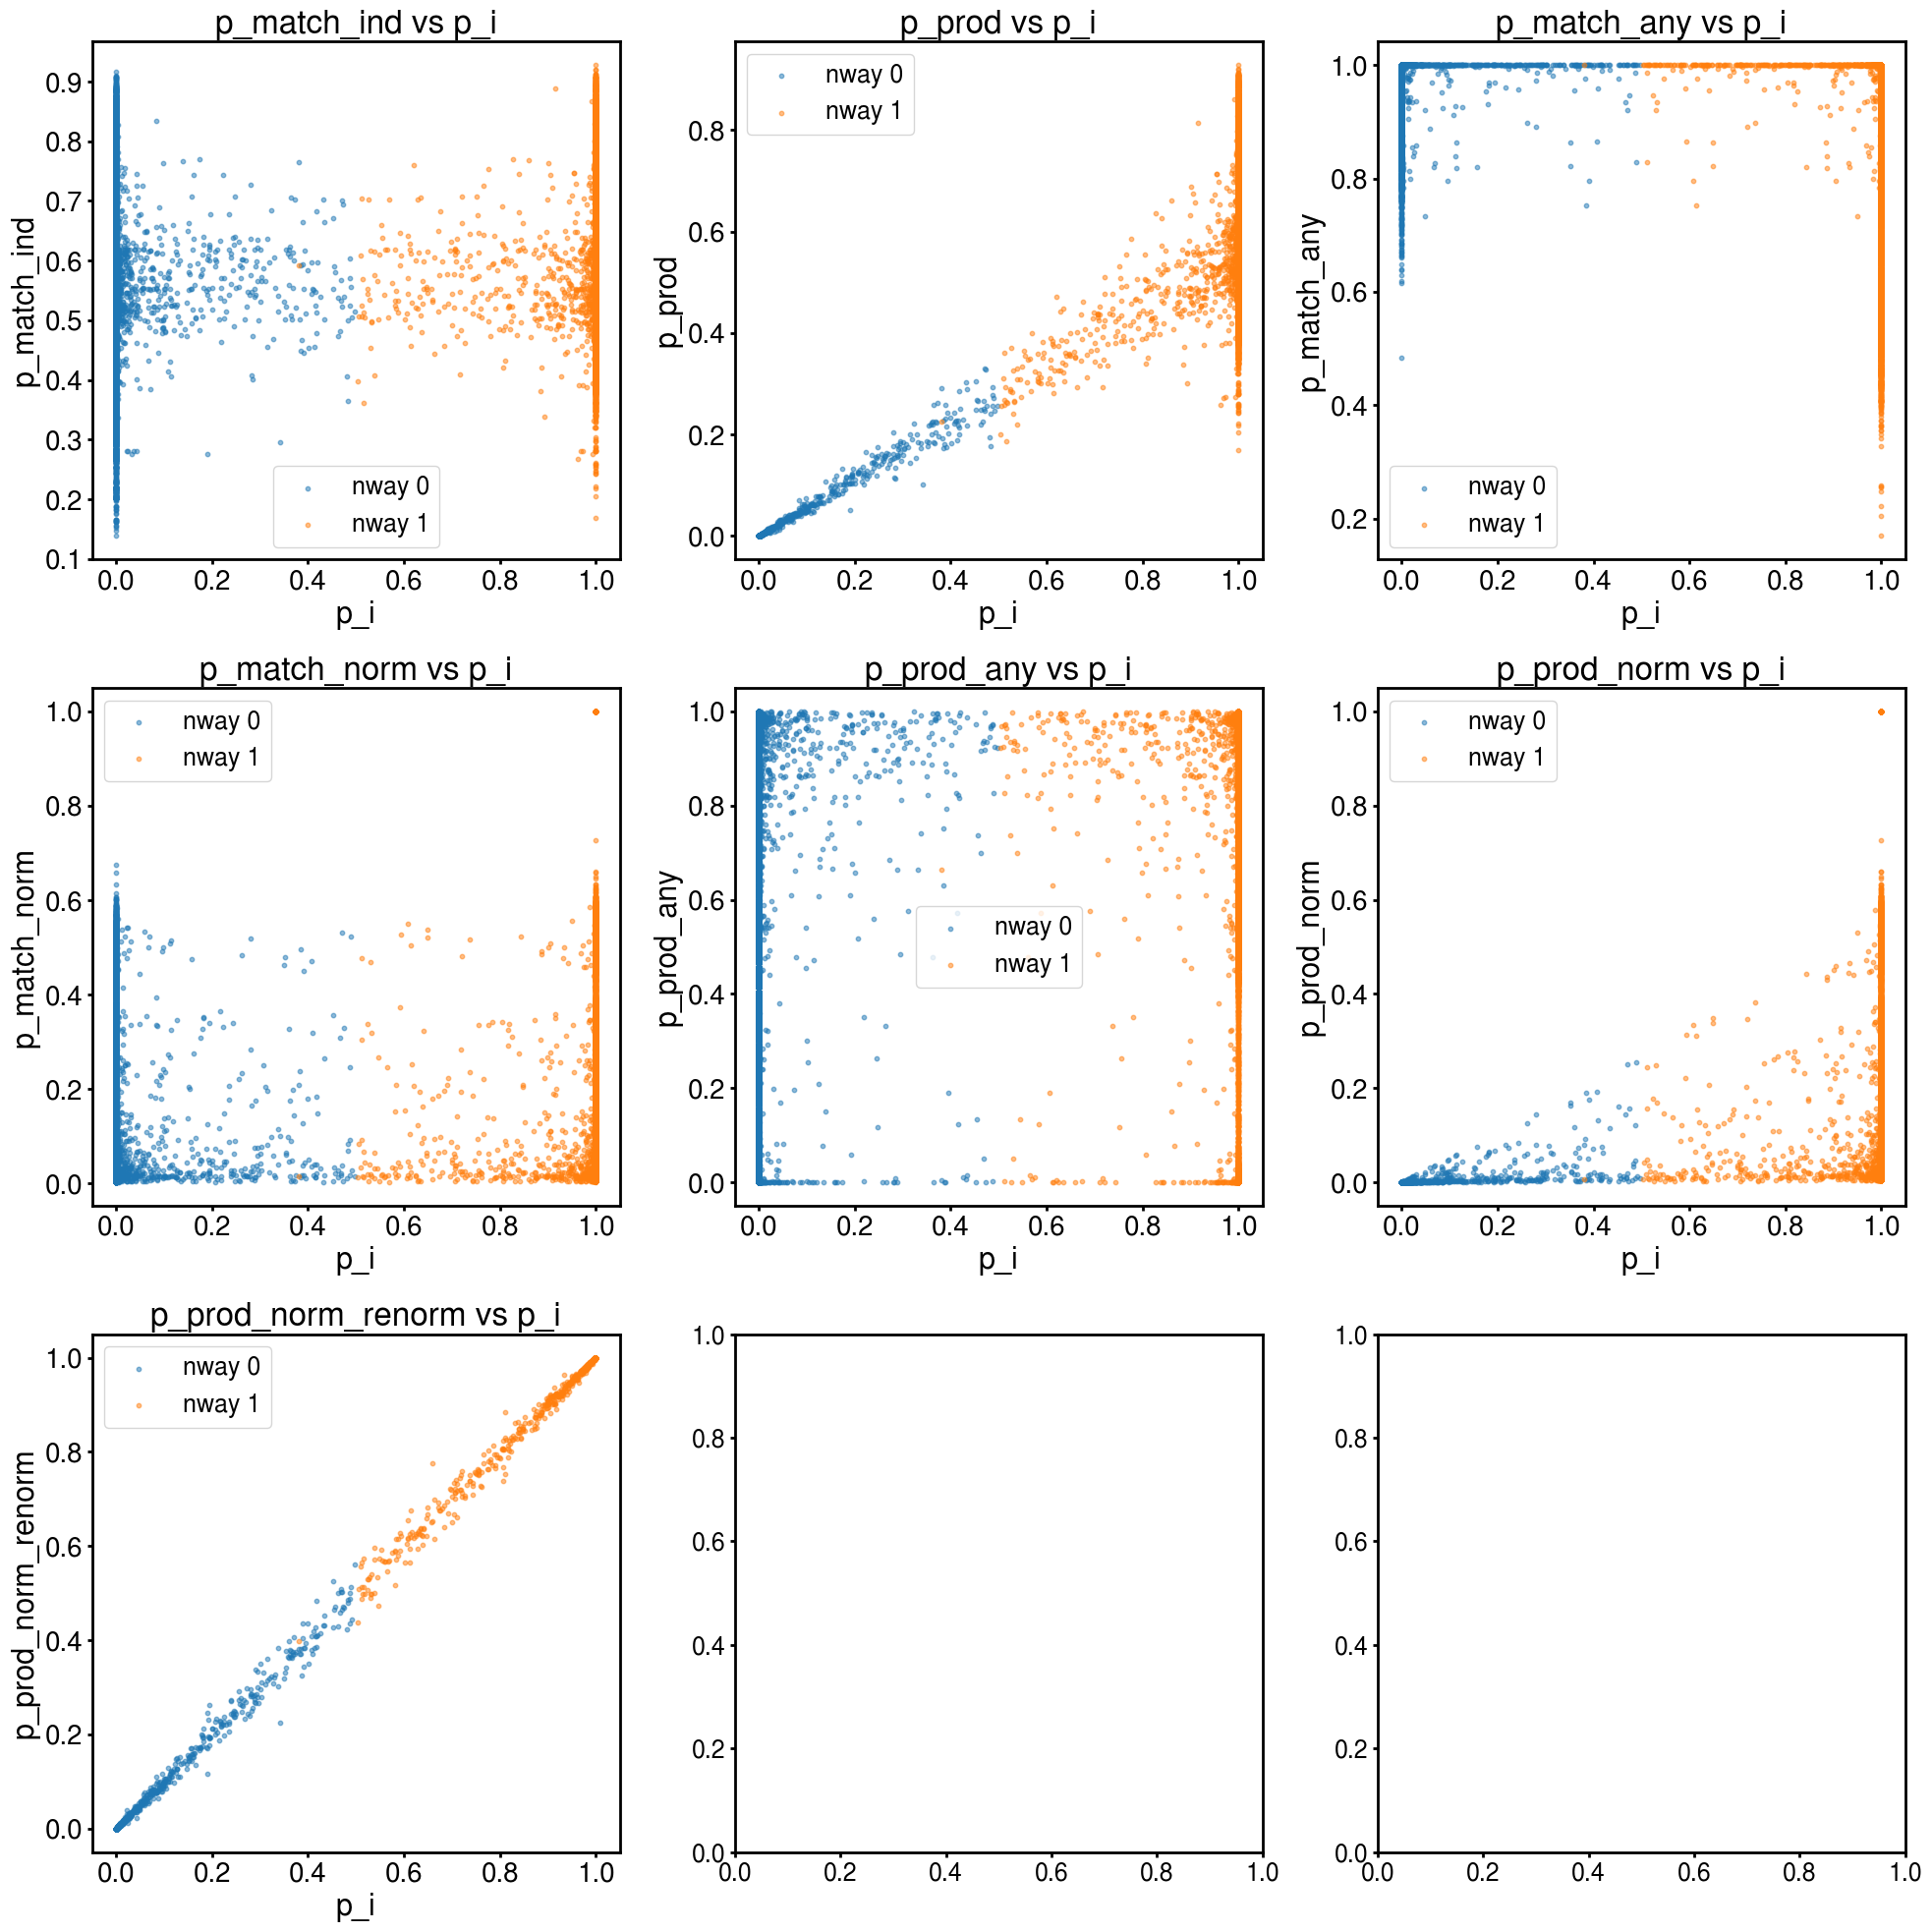

In [7]:
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18  # Increased from 12
plt.rcParams['axes.linewidth'] = 2  # Increased from 1.5
plt.rcParams['xtick.major.width'] = 2  # Increased from 1.5
plt.rcParams['ytick.major.width'] = 2  # Increased from 1.5

# 1. scatter plots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Increased figure size
axes = axes.ravel()
for i, prob in enumerate(probabilities[1:]):
    for label in [0, 1]:
        mask = df['benchmark_label'] == label
        axes[i].scatter(df.loc[mask, 'p_i'], df.loc[mask, prob], 
                        alpha=0.5, s=10, label=f'nway {label}')  # Smaller points
    axes[i].set_xlabel('p_i', fontsize=22)
    axes[i].set_ylabel(prob, fontsize=22)
    axes[i].set_title(f'{prob} vs p_i', fontsize=24)
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].legend(fontsize=18)
plt.tight_layout()
plt.show()

In [8]:
# 2. confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50})
    plt.title(title, fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()
    
    # percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 50})
    plt.title(title + ' (Percentage)', fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()

In [21]:

# function to get predictions based on max probability per group
def get_max_prob_predictions(df, prob_col):
    # identify max probability for each group
    idx = df.groupby('csc21_name')[prob_col].idxmax()
    
    # create a new column with 0s
    df['pred'] = 0
    
    # set 1 for the max probability in each group
    df.loc[idx, 'pred'] = 1
    
    return df['pred']

# get predictions for each method
bayesian_pred = get_max_prob_predictions(df, 'p_i')
lgbm_pred = get_max_prob_predictions(df, 'p_match_ind')
lgbm_norm_pred = get_max_prob_predictions(df, 'p_match_norm')
combined_pred = get_max_prob_predictions(df, 'p_prod')
combined_pred_simple = get_max_prob_predictions(df, 'p_prod_norm')

# true labels
true_labels = df['benchmark_label']

plot_confusion_matrix(true_labels, bayesian_pred, 'Confusion Matrix - NWAY')
plot_confusion_matrix(true_labels, lgbm_pred, 'Confusion Matrix - LGBM Method')
plot_confusion_matrix(true_labels, lgbm_norm_pred, 'Confusion Matrix - LGBM Method Normalized')
plot_confusion_matrix(true_labels, combined_pred, 'Confusion Matrix - Product')
plot_confusion_matrix(true_labels, combined_pred_simple, 'Confusion Matrix - Product with p_match normalized')

# # 3. performance metrics
# def print_performance_metrics(y_true, y_pred, title):
#     print(f"\n{title}")
#     print(classification_report(y_true, y_pred))

# print_performance_metrics(true_labels, bayesian_pred, 'Bayesian Method')
# print_performance_metrics(true_labels, lgbm_pred, 'LGBM Method')
# print_performance_metrics(true_labels, lgbm_norm_pred, 'LGBM Method Normalized')
# print_performance_metrics(true_labels, combined_pred, 'Product')

# # 4. method agreement
# plot_confusion_matrix(bayesian_pred, lgbm_pred, 'Method Agreement - Bayesian vs LGBM')

# # print agreement percentage
# agreement = (bayesian_pred == lgbm_pred).mean()
# print(f"\nMethod Agreement: {agreement:.2%}")

NameError: name 'plot_confusion_matrix' is not defined

In [34]:
df_different = df[df.benchmark_label != combined_pred]

In [38]:
df_different.drop('pred', axis=1).to_csv('different_matches.csv')

In [39]:
df_different

,csc21_name,csc21_ra,csc21_dec,gaia3_source_id,gaia3_ra,gaia3_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,...,benchmark_label,sqrt(pmra^2+pmdec^2),p_match_ind,p_prod,p_match_any,p_match_norm,p_prod_any,p_prod_norm,p_prod_norm_renorm,pred
39896,2CXO J084414.2+022620,131.0593,2.439163,3079006288647161856,131.059342,2.439062,21.119478,NaN,NaN,NaN,...,1,NaN,0.616329,0.326790,0.919888,0.467867,0.918379,0.248072,0.498079,0
39897,2CXO J084414.2+022620,131.0593,2.439163,3079006292943629568,131.059230,2.439256,20.148407,18.089436,17.619710,0.469725,...,0,NaN,0.700987,0.329310,0.919888,0.532133,0.918379,0.249985,0.501921,1
40642,2CXO J090751.8+622441,136.9661,62.411400,1043171900349952128,136.966113,62.411523,21.598860,NaN,NaN,NaN,...,1,NaN,0.501625,0.274267,0.975681,0.265982,0.973227,0.145428,0.474182,0
40643,2CXO J090751.8+622441,136.9661,62.411400,1043171900351444992,136.966377,62.411398,20.182755,19.795792,18.536343,1.259449,...,0,0.949564,0.671019,0.304134,0.975681,0.355802,0.973227,0.161264,0.525818,1
235313,2CXO J175842.5-290456,269.6773,-29.082330,4062350840779139968,269.677254,-29.082268,18.981483,NaN,NaN,NaN,...,0,NaN,0.567462,0.265882,1.000000,0.016206,0.937144,0.007593,0.501875,1
235322,2CXO J175842.5-290456,269.6773,-29.082330,4062350840838717312,269.677359,-29.082391,17.601973,NaN,NaN,NaN,...,1,9.443356,0.496552,0.263895,1.000000,0.014181,0.937144,0.007536,0.498125,0
248340,2CXO J180516.9-283401,271.3206,-28.567160,4062435877180078080,271.320614,-28.567072,16.054716,16.317596,15.059883,1.257713,...,0,3.834912,0.515139,0.256125,1.000000,0.015398,0.921833,0.007656,0.561577,1
248361,2CXO J180516.9-283401,271.3206,-28.567160,4062435881117722368,271.320599,-28.567256,17.638628,NaN,NaN,NaN,...,1,NaN,0.397682,0.199957,1.000000,0.011887,0.921833,0.005977,0.438423,0
269207,2CXO J182442.2-245447,276.1759,-24.913220,4077189368694264704,276.175600,-24.913424,17.205957,NaN,NaN,NaN,...,0,8.695386,0.532348,0.249946,1.000000,0.021466,0.051006,0.010078,0.509795,1
269225,2CXO J182442.2-245447,276.1759,-24.913220,4077189403054000768,276.176194,-24.913402,15.837197,16.285496,15.007857,1.277638,...,1,2.157673,0.453061,0.240341,1.000000,0.018269,0.051006,0.009691,0.490205,0


In [5]:
df_fulls = pd.read_parquet('../out_data/nway_csc21_gaia3_full.parquet', index=False, engine='fastparquet')
print('finito!')

finito!


In [8]:
df_fulls.shape

(2402340, 74)

In [15]:
del df_fulls